**What I want to do: **Play the dogs versus cats competition on kaggle by fine-tuning a pretrained deep learning model, specifically the Vgg16 model.

Step 7 onwards. For Steps 1 to 6, please see the pre-processing notebook

### Admin stuff

In [1]:
%matplotlib inline

## Step7: Understand how the training setup works by prototyping

#### Define paths for training, test and validation sets

In [2]:
data_dir = "data_redux"
train_path = "data_redux/train/"
test_path = "data_redux/test/"
validation_path = "data_redux/valid/"
sample_train_path = "data_redux/sample/train/"
sample_validation_path = "data_redux/sample/valid/"
results_path = "data_redux/results/"

In [3]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from datetime import datetime
import re

Jeremy has created a "utils.py" file with a whole host of convenience utility functions. I need to familiarise this in greater detail, especially the "plots" function. But lets simply use this for now.

In [4]:
import utils; reload(utils)
from utils import plots
from utils import save_array, load_array

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


### Use the pre-trained VGG model to classify our data

Jeremy has tried to stick to the sklearn import instantiate fit predict paradigm by building a VGG class (I quickly looked online and I think the vgg class is a custom-built class). Let me run this step by step:

In [5]:
# import
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## Train dogscats model based on the punchline

In [6]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size = 64

In [7]:
# instantiate
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [8]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(validation_path, batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1
20000/20000 [==============================] - 626s - loss: 0.2067 - acc: 0.9570 - val_loss: 0.0738 - val_acc: 0.9826


Nice to see validation accuracy of 98%!

## Save full training 1 epoch weights

In [13]:
#%mkdir data_redux/results

In [12]:
vgg.model.save_weights(results_path+'fulltraining.h5')

In [3]:
!ls data_redux/results/

fulltraining.h5


#### Picking up from where I left off the other day...

In [8]:
vgg.model.load_weights(results_path+'fulltraining.h5')

## Run it on test set

In [14]:
!ls data_redux/test | wc -l

12500


In [19]:
#%mkdir data_redux/test/test
#!mv data_redux/test/* data_redux/test/test/

12500


In [20]:
batches, predict = vgg.test(test_path, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [22]:
predict[:5]

array([[  1.0781e-07,   1.0000e+00],
       [  1.0000e+00,   5.7603e-11],
       [  1.0000e+00,   2.9557e-07],
       [  2.1490e-09,   1.0000e+00],
       [  1.2420e-10,   1.0000e+00]], dtype=float32)

In [24]:
batches.filenames[:5]

['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/10000.jpg']

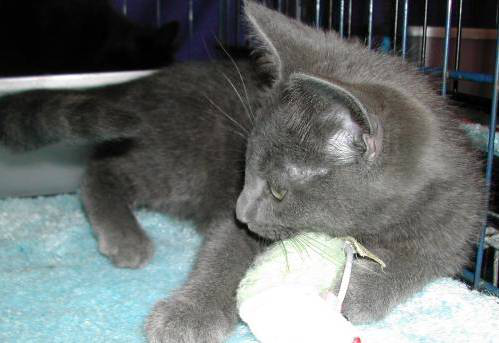

In [27]:
from PIL import Image
Image.open(test_path+batches.filenames[2])

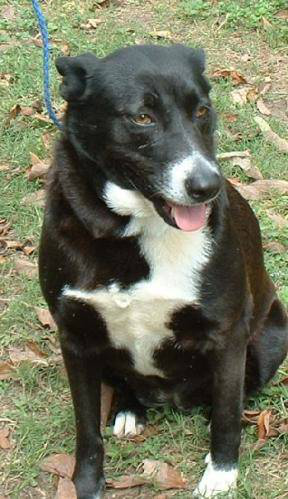

In [28]:
Image.open(test_path+batches.filenames[3])

Saving our results so that we can use this for later.

In [29]:
save_array(results_path + 'test_preds.dat', predict2)
save_array(results_path + 'filenames.dat', batches.filenames)

### Load the array values 

In [69]:
predict = load_array(results_path + 'test_preds.dat')

In [70]:
#(predict==predict2).all()

True

## Submit to kaggle!

### Do I need to pre-process results?

This is the way kaggle expects. For each image in the test set, you must submit a probability that image is a dog. Submissions are scored on the log loss:  $$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right],$$

where:<br>
- n is the number of images in the test set
- y_hat(i) is the predicted probability of the image being a dog
- y(i) is 1 if the image is a dog, 0 if cat
- log() is the natural (base e) logarithm
 
A smaller log loss is better. And my file needs to be structured like so:

In [68]:
!head data_redux/sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5
7,0.5
8,0.5
9,0.5


**HOWEVER,** These are the results my model gave me.

In [67]:
predict[:5] #where dog probability is the second probability

array([[  1.0781e-07,   1.0000e+00],
       [  1.0000e+00,   5.7603e-11],
       [  1.0000e+00,   2.9557e-07],
       [  2.1490e-09,   1.0000e+00],
       [  1.2420e-10,   1.0000e+00]], dtype=float32)

In [63]:
batches.filenames[:5]

['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/10000.jpg']

### Perform pre-processing